Bitcoin LSTM vs ARIMA

# Train ARIMA

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from matplotlib import pyplot as plt

In [76]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')

In [77]:
def load_data(filename):
    df = pd.read_csv('{0}'.format(filename))
    df['Seconds'] = df.Timestamp.values.astype(int) # rename the field
    df.Timestamp = pd.to_datetime(df.Timestamp, unit='s') # true timestamp
    df = df[df.Open.notnull()] # remove fields without data

    df = df.reset_index().drop('index', axis=1).reset_index()
    df['counter'] = df.index
    df = df.drop('index', axis=1)
    df = df.set_index('Seconds')
    df_original = df.copy()
    
    # downsample to days
    df = df.reset_index().set_index('Timestamp').resample('D').mean()
    df = pd.DataFrame(df)
    return (df,df_original)



In [78]:
# Same dataset to be used later for LSTM
df_lstm = pd.read_csv("bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")

In [79]:
# Entries missing in both datasets
df2,_ = load_data('bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')
df4,_ = load_data('bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv')
print('entries missing in df2', sum(df2.Weighted_Price.isnull()))
print('entries missing in df4', sum(df4.Weighted_Price.isnull()))

entries missing in df2 34
entries missing in df4 3


In [80]:
df2.head()

,Seconds,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,counter
Timestamp,,,,,,,,,
2014-12-01,1.417414e+09,335.000000,335.000000,335.000000,335.000000,0.014139,4.881387,335.000000,1.5
2014-12-02,1.417528e+09,377.821429,377.857143,377.821429,377.857143,2.144800,810.724043,377.854911,7.0
2014-12-03,1.417612e+09,377.818333,377.818333,377.818333,377.818333,0.091101,34.419664,377.818333,13.5
2014-12-04,1.417658e+09,377.100000,377.100000,377.100000,377.100000,0.010000,3.771000,377.100000,17.0
2014-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
#Forward Filling NaN values
df2['Seconds'].fillna(method='ffill', inplace=True)
df2['Open'].fillna(method='ffill', inplace=True)
df2['High'].fillna(method='ffill', inplace=True)
df2['Low'].fillna(method='ffill', inplace=True)
df2['Close'].fillna(method='ffill', inplace=True)

df2['Volume_(BTC)'].fillna(method='ffill', inplace=True)
df2['Volume_(Currency)'].fillna(method='ffill', inplace=True)
df2['Weighted_Price'].fillna(method='ffill', inplace=True)
df2['counter'].fillna(method='ffill', inplace=True)



In [82]:
df2.head()

,Seconds,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,counter
Timestamp,,,,,,,,,
2014-12-01,1.417414e+09,335.000000,335.000000,335.000000,335.000000,0.014139,4.881387,335.000000,1.5
2014-12-02,1.417528e+09,377.821429,377.857143,377.821429,377.857143,2.144800,810.724043,377.854911,7.0
2014-12-03,1.417612e+09,377.818333,377.818333,377.818333,377.818333,0.091101,34.419664,377.818333,13.5
2014-12-04,1.417658e+09,377.100000,377.100000,377.100000,377.100000,0.010000,3.771000,377.100000,17.0
2014-12-05,1.417658e+09,377.100000,377.100000,377.100000,377.100000,0.010000,3.771000,377.100000,17.0


In [83]:
#We prefer Coinbase over BitStamp since it is from the years 2014-2019. This is after the initial spike of 2012-2013

#Setting date time to System Time
import pandas as pd
from datetime import datetime, timedelta

def posix_time(dt):
    return (dt - datetime(1970, 1, 1)) / timedelta(seconds=1)



In [84]:
_ = df2.reset_index().Timestamp.apply(posix_time)
_ = np.asarray(_, dtype=date)
df2['Date'] = _
df2.head()

,Seconds,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,counter,Date
Timestamp,,,,,,,,,,
2014-12-01,1.417414e+09,335.000000,335.000000,335.000000,335.000000,0.014139,4.881387,335.000000,1.5,1.41739e+09
2014-12-02,1.417528e+09,377.821429,377.857143,377.821429,377.857143,2.144800,810.724043,377.854911,7.0,1.41748e+09
2014-12-03,1.417612e+09,377.818333,377.818333,377.818333,377.818333,0.091101,34.419664,377.818333,13.5,1.41756e+09
2014-12-04,1.417658e+09,377.100000,377.100000,377.100000,377.100000,0.010000,3.771000,377.100000,17.0,1.41765e+09
2014-12-05,1.417658e+09,377.100000,377.100000,377.100000,377.100000,0.010000,3.771000,377.100000,17.0,1.41774e+09


In [85]:
#Making sure that there are no missing entries in df4
missing_entries_timestamp = df2[df2.Weighted_Price.isnull()].index
missing_entries_timestamp

DatetimeIndex([], dtype='datetime64[ns]', name='Timestamp', freq='D')

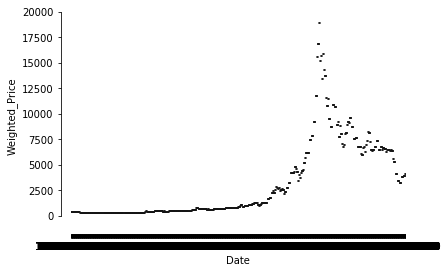

In [86]:
#Making data stationary by taking the log-difference followed by rolling average
sns.boxplot(x="Date", y="Weighted_Price", data=df2, palette="PRGn")
sns.despine(offset=10, trim=True)
plt.show()

In [87]:
#Date Ranges
df = df2.Weighted_Price
df = pd.DataFrame(df)
df.index.min(), df.index.max()

(Timestamp('2014-12-01 00:00:00'), Timestamp('2019-01-07 00:00:00'))

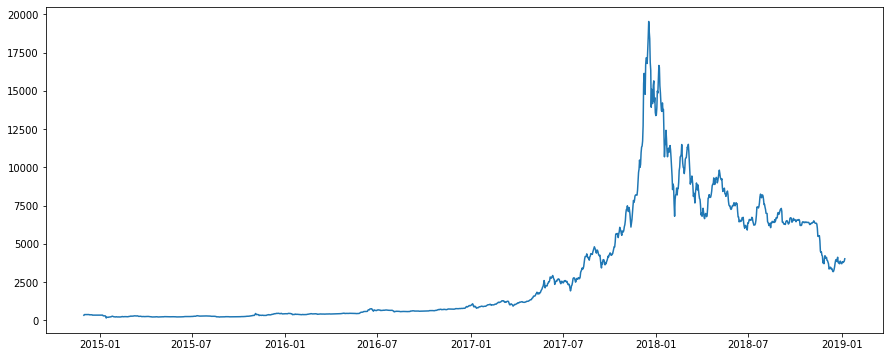

In [88]:
plt.figure(figsize=(15,6))
plt.plot(df)
plt.show()

In [89]:
# Testing stationarity using Dickey-Fuller test

def test_stationarity(timeseries):
    #Stats
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    Dickey_Fuller_test(timeseries)
    
def Dickey_Fuller_test(timeseries):
    #Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



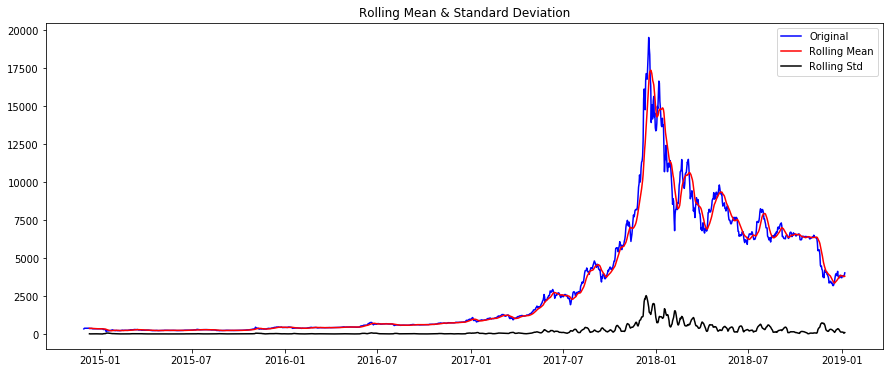

Results of Dickey-Fuller Test:
Test Statistic                   -1.801372
p-value                           0.379781
#Lags Used                       24.000000
Number of Observations Used    1474.000000
Critical Value (1%)              -3.434794
Critical Value (5%)              -2.863503
Critical Value (10%)             -2.567815
dtype: float64


In [90]:
test_stationarity(df.Weighted_Price)

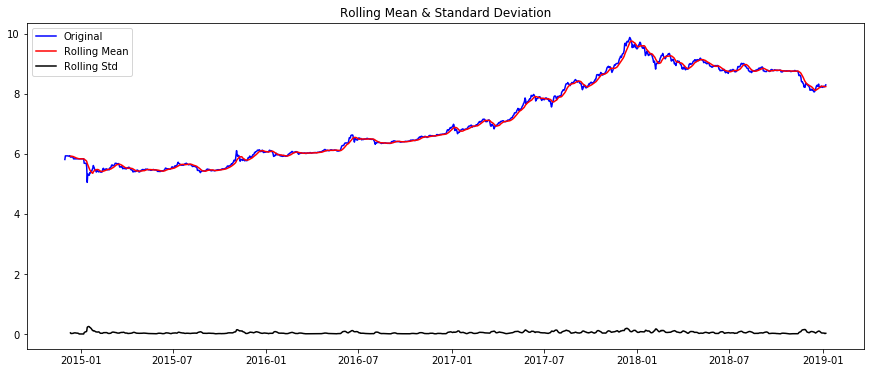

Results of Dickey-Fuller Test:
Test Statistic                   -0.648449
p-value                           0.859655
#Lags Used                        7.000000
Number of Observations Used    1491.000000
Critical Value (1%)              -3.434743
Critical Value (5%)              -2.863480
Critical Value (10%)             -2.567803
dtype: float64


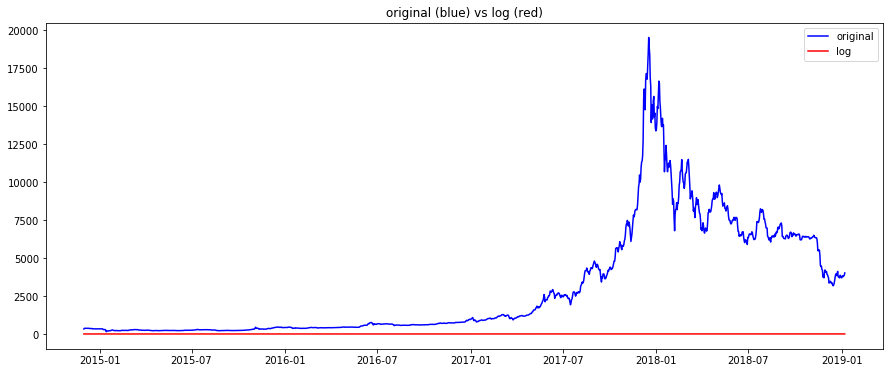

In [91]:
#Flatten the curve to a near linear line.

ts_df_log = np.log(df)
test_stationarity(ts_df_log.Weighted_Price)
plt.figure(figsize=(15,6))
plt.plot(df, color='blue', label='original')
plt.plot(ts_df_log, color='red', label='log')
plt.title('original (blue) vs log (red)')
plt.legend(loc='best')
plt.show()

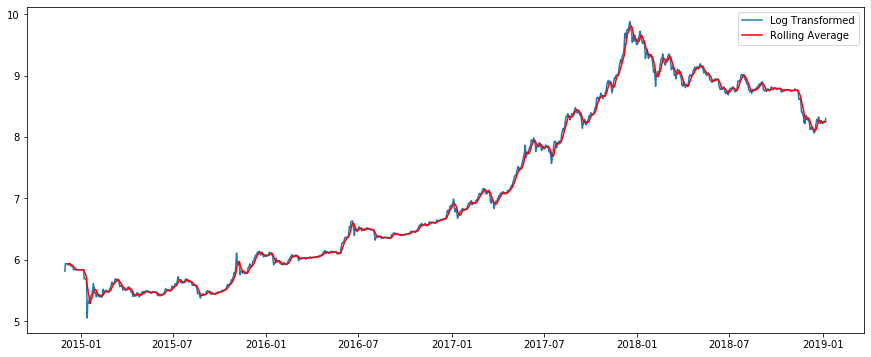

In [92]:
#Rolling Average
window = 7
Rolling_average = ts_df_log.rolling(window = window, center= False).mean()
ts_df_log_rolling = Rolling_average.dropna()
plt.figure(figsize=(15,6))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

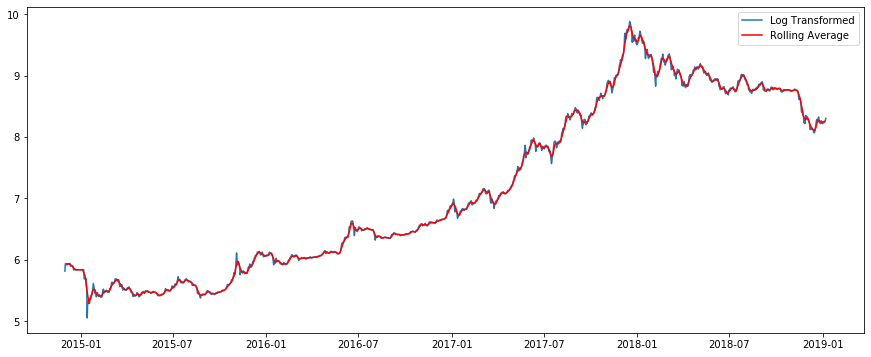

In [93]:
# Fix Rolling Average to get a more tight fit
window = 7
shift_by_days = -2
Rolling_average = ts_df_log.rolling(window = window, center= False).mean()
ts_df_log_rolling_temp = Rolling_average.shift(shift_by_days).dropna()
plt.figure(figsize=(15,6))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling_temp, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

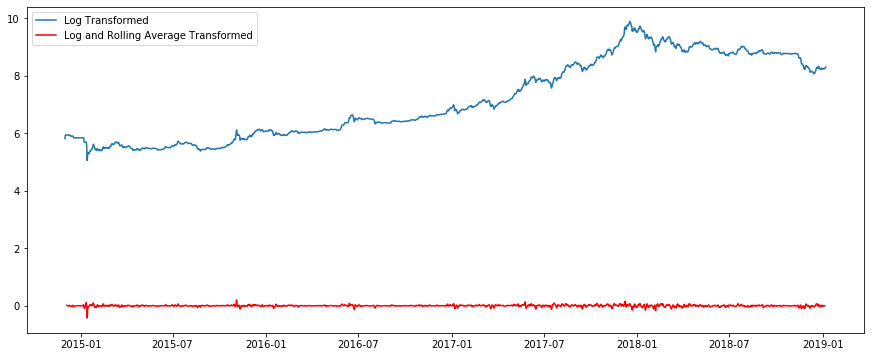

Results of Dickey-Fuller Test:
Test Statistic                -1.435010e+01
p-value                        1.025185e-26
#Lags Used                     6.000000e+00
Number of Observations Used    1.486000e+03
Critical Value (1%)           -3.434758e+00
Critical Value (5%)           -2.863487e+00
Critical Value (10%)          -2.567807e+00
dtype: float64


In [94]:
# Log and Rolling Average Transformed
ts_df_log_rolling = (ts_df_log - ts_df_log_rolling_temp).dropna()
plt.figure(figsize=(15,6))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling, color = 'red', label = 'Log and Rolling Average Transformed')
plt.legend(loc = 'best')
plt.show()
Dickey_Fuller_test(ts_df_log_rolling.Weighted_Price)

In [95]:
# Building the model using ACF and PACF to justify either AR, MA, ARMA, or ARIMA.

# ACF / PACF plots
lag = 20
lag_pacf = pacf(ts_df_log_rolling, nlags=lag, method='ols')
lag_acf = acf(ts_df_log_rolling, nlags=lag)

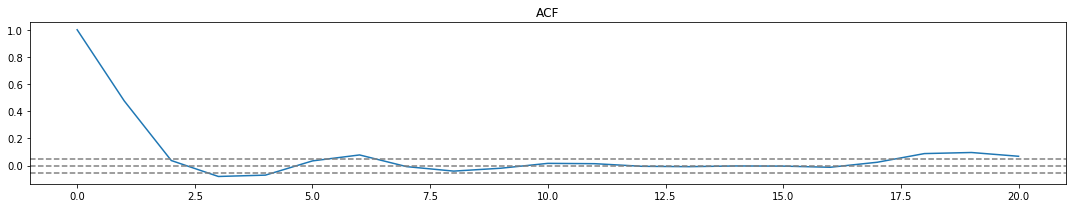

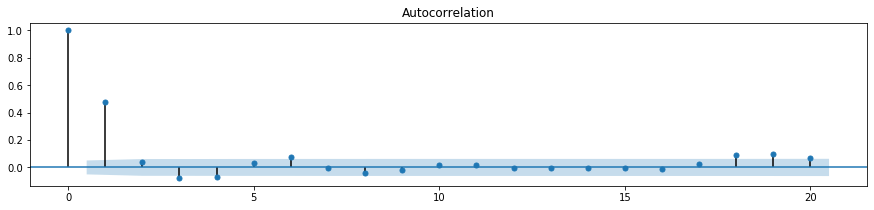

In [96]:
#Plotting ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_df_log_rolling, ax=plt.gca(),lags=lag)
plt.show()

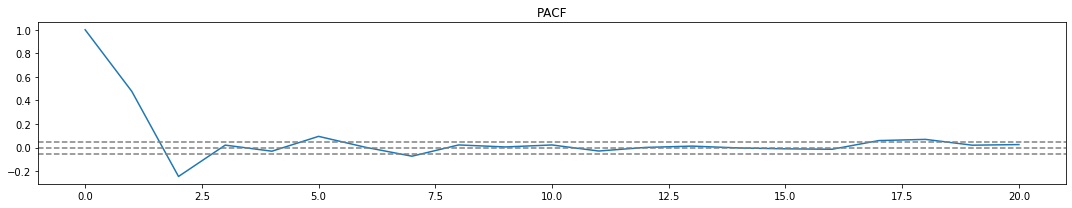

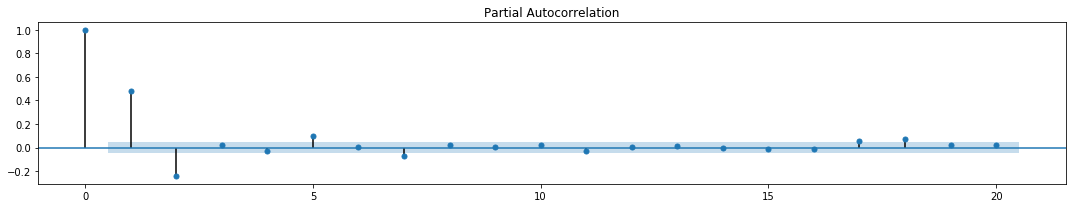

In [97]:
#Plotting PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_df_log_rolling, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [98]:
#First Entry to break the upper confidence level is at the value 2 in the above figure
#Therefore, we take p=2 and q=2 
p=2
q=2
d=1

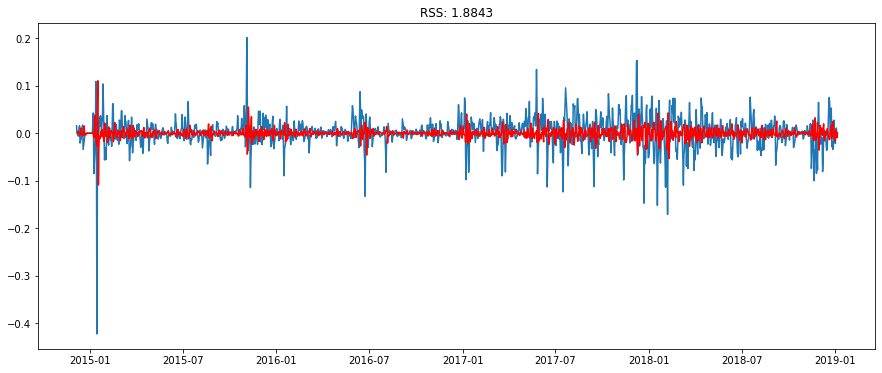

In [99]:
#AR Model
model = ARIMA(ts_df_log_rolling, order=(p, d, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(15,6))
plt.plot(ts_df_log_rolling)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_df_log_rolling.Weighted_Price).dropna()**2))
plt.show()

In [100]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.Weighted_Price   No. Observations:                 1492
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3095.025
Method:                       css-mle   S.D. of innovations              0.030
Date:                Sun, 15 Dec 2019   AIC                          -6182.050
Time:                        17:22:53   BIC                          -6160.818
Sample:                    12-06-2014   HQIC                         -6174.138
                         - 01-05-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.922e-06      0.001     -0.012      0.990      -0.001       0.001
ar.L1.D.Weighted_Price    -0.1058      0.025     -4.310      0.000      -0.154      -0.058
ar.L2.D.Weighted_Price    -0.3156      0.025    -12.859      0.000      -0.364      -0.268
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1677           -1.7721j            1.7800           -0.2650
AR.2           -0.1677           +1.7721j            1.7800            0.2650
-----------------------------------------------------------------------------
"""

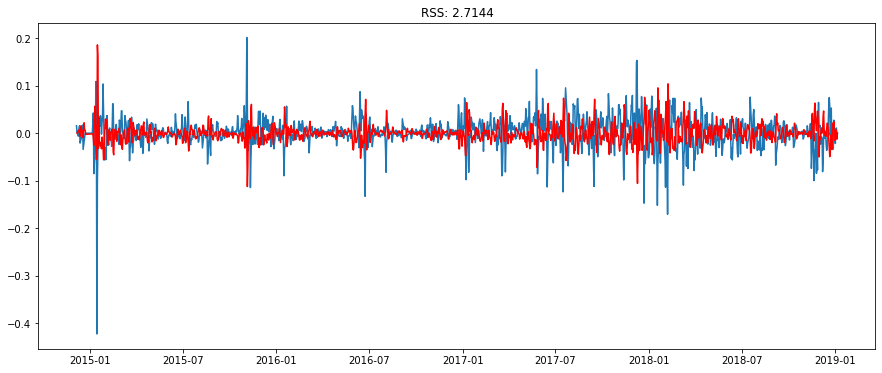

In [101]:
#MA Model
model = ARIMA(ts_df_log_rolling, order=(0, d, q))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize=(15,6))
plt.plot(ts_df_log_rolling)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_df_log_rolling.Weighted_Price).dropna()**2))
plt.show()

In [102]:
results_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.Weighted_Price   No. Observations:                 1492
Model:                 ARIMA(0, 1, 2)   Log Likelihood                3272.891
Method:                       css-mle   S.D. of innovations              0.027
Date:                Sun, 15 Dec 2019   AIC                          -6537.783
Time:                        17:22:54   BIC                          -6516.551
Sample:                    12-06-2014   HQIC                         -6529.871
                         - 01-05-2019                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -8.784e-07   6.65e-06     -0.132      0.895   -1.39e-05    1.21e-05
ma.L1.D.Weighted_Price    -0.4473      0.020    -22.634      0.000      -0.486      -0.409
ma.L2.D.Weighted_Price    -0.5444      0.020    -27.576      0.000      -0.583      -0.506
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0054           +0.0000j            1.0054            0.0000
MA.2           -1.8271           +0.0000j            1.8271            0.5000
-----------------------------------------------------------------------------
"""

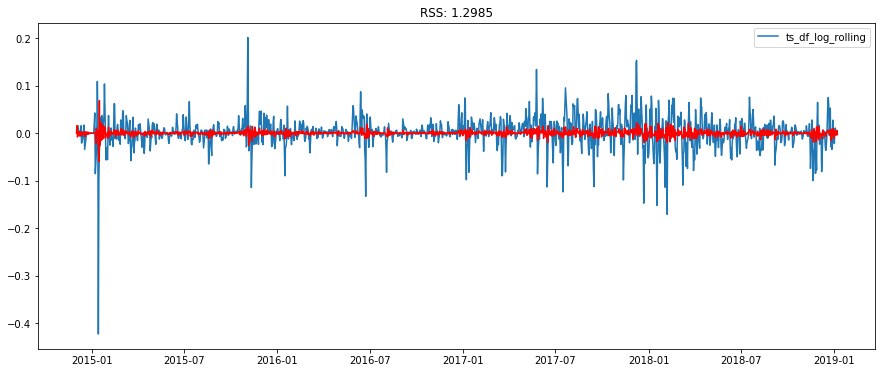

In [103]:
#ARIMA Model
model = ARIMA(ts_df_log, order=(p, d, q))  
results_ARIMA = model.fit(disp=-1, trend='nc')
plt.figure(figsize=(15,6))
plt.plot(ts_df_log_rolling, label='ts_df_log_rolling')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_df_log_rolling.Weighted_Price).dropna()**2))
plt.legend(loc='best')
plt.show()

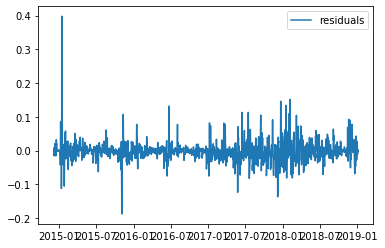

In [104]:
#Plotting the residuals
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ts_df_log_rolling.columns
x = x - ts_df_log_rolling
# x = x.cumsum()
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

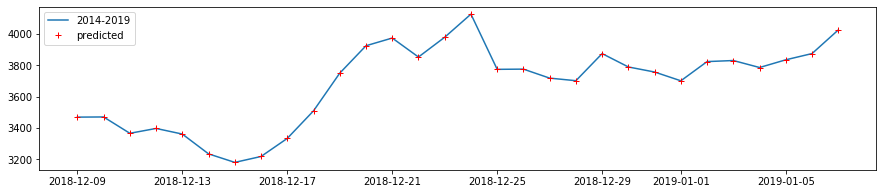

In [105]:
#Forecasting using the ARIMA Model

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_df_log.Weighted_Price, index=ts_df_log.index)
predictions_ARIMA = np.exp(predictions_ARIMA_log[len(predictions_ARIMA_log)-30:])

plt.figure(figsize=(15,3))
plt.plot(df[len(df)-30:], label='2014-2019')
plt.plot(predictions_ARIMA, 'r+', label='predicted')
plt.legend(loc='best')
plt.show()

In [106]:
#Calculate MSE, MAE and accuracy score for ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(df[len(df)-30:],predictions_ARIMA)



3.970466940254533e-24

In [107]:
# Mean Absolute Error for ARIMA
mean_absolute_error(df[len(df)-30:],predictions_ARIMA)

1.6674069532503684e-12

# Train LSTM

In [108]:
#Importing dataset and encoding the date
df_lstm['date'] = pd.to_datetime(df_lstm['Timestamp'],unit='s').dt.date
group = df_lstm.groupby('date')
Real_Price = group['Weighted_Price'].mean()



In [109]:
#Splitting Data
# training set  = all days except the last 30
# test set = last 30 days
prediction_days = 30
df_lstm_train= Real_Price[:len(Real_Price)-prediction_days]
df_lstm_test= Real_Price[len(Real_Price)-prediction_days:]

In [110]:
#Data PreProcessing
training_set = df_lstm_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [111]:
#Importing Keras Library/Packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [112]:
# Initialize RNN
regressor = Sequential()

# Add input layer and LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Add output layer
regressor.add(Dense(units = 1))

# Compiling RNN
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

# Fitting RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
1434/1434 [==============================] - 2s 1ms/step - loss: 0.2044
Epoch 2/100
1434/1434 [==============================] - 1s 544us/step - loss: 0.0339
Epoch 3/100
1434/1434 [==============================] - 1s 501us/step - loss: 0.0302
Epoch 4/100
1434/1434 [==============================] - 1s 522us/step - loss: 0.0270
Epoch 5/100
1434/1434 [==============================] - 1s 503us/step - loss: 0.0232
Epoch 6/100
1434/1434 [==============================] - 1s 502us/step - loss: 0.0186
Epoch 7/100
1434/1434 [==============================] - 1s 511us/step - loss: 0.0131
Epoch 8/100
1434/1434 [==============================] - 2s 1ms/step - loss: 0.0079
Epoch 9/100
1434/1434 [==============================] - 1s 490us/step - loss: 0.0035
Epoch 10/100
1434/1434 [==============================] - 1s 497us/step - loss: 0.0012
Epoch 11/100
1434/1434 [==============================] - 1s 500us/step - loss: 6.9269e-04
Epoch 12/100
1434/1434 [============================

In [113]:
# Making predictions
test_set = df_lstm_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs) # predict using the model
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price) # reverse the minmax scaling

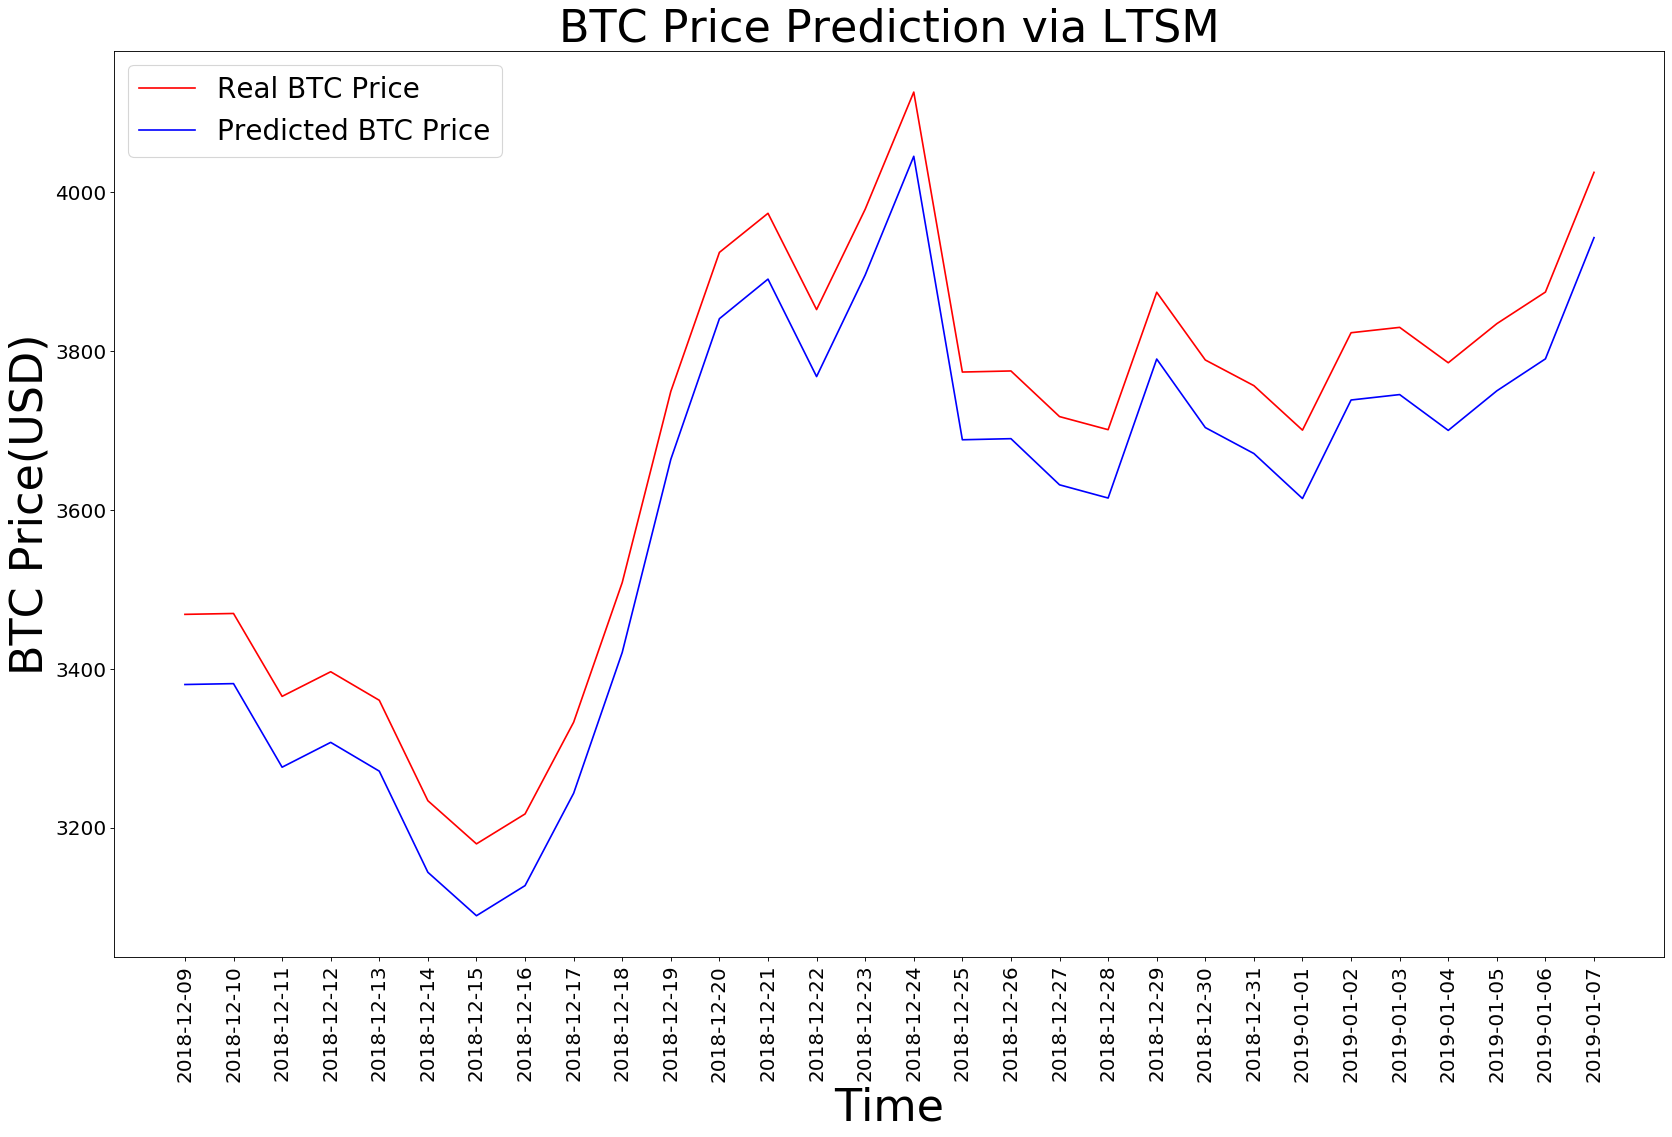

In [114]:
# Visualise the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction via LTSM', fontsize=40)
df_lstm_test = df_lstm_test.reset_index()
x=df_lstm_test.index
labels = df_lstm_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [115]:
#Calculate MSE, MAE and accuracy score

from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(test_set,predicted_BTC_price)

7401.688158147715

In [116]:
# Mean Absolute Error for LTSM
mean_absolute_error(test_set,predicted_BTC_price)

85.99500521266447

# Ensemble via Bagging

In [117]:
ensemble_results = []

# set the weights to about half each
rnnWeight = 0.5
arimaWeight = 0.5

# seperate the relevant predictions for arima
arimaResults = predictions_ARIMA[len(predictions_ARIMA)-30:]

# perform bagging for each days result
for i in range(len(test_set)):
    ensemble_results.append(arimaWeight * arimaResults[i] + rnnWeight * predicted_BTC_price[i])

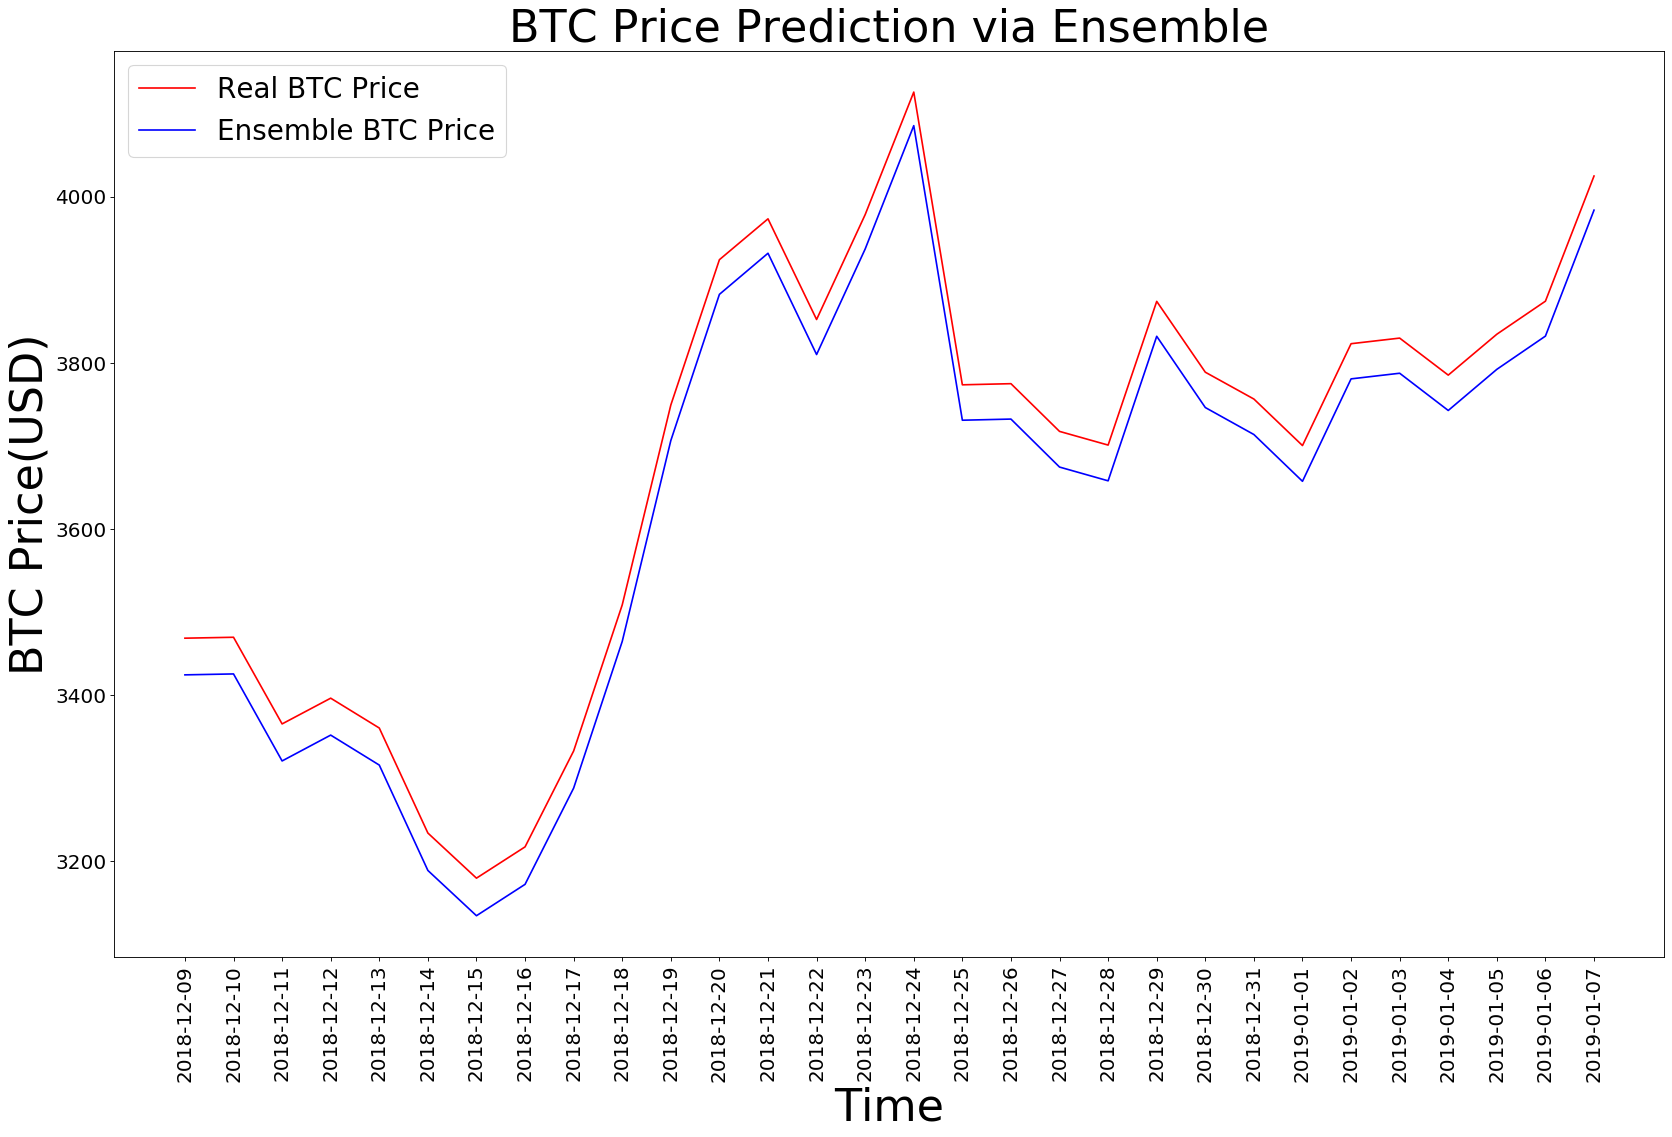

In [118]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(ensemble_results, color = 'blue', label = 'Ensemble BTC Price')
plt.title('BTC Price Prediction via Ensemble', fontsize=40)
df_lstm_test = df_lstm_test.reset_index()
x=df_lstm_test.index
labels = df_lstm_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()


In [119]:
# Mean Absolute Error for Ensemble Learning
mean_absolute_error(test_set,ensemble_results)

42.99748730901864